In [1]:
import numpy as np
import tensorflow as tf
import gpflow

from matplotlib import pyplot as plt

import function as fun
import domain as dom
import safe

# System modeling

When modeling a real-world physical system, it is important to account for uncertainty in model parameters. The modeling could then be expressed as an autonomous system

$\dot{x} = f(x) + g(x)$,

where $x$ and $\dot{x}$ are the state and its time-derivative of the modeled system, and where $f(x)$ and $g(x)$ describe prior knowledge and uncertainty about the system, respectively.

### Domain discretization

Even though, the real-world physical system mentioned above is considered to operate in continuous time, the state space of this system is discretized to perform safety analysis. In particular, functions $f(x)$ and $g(x)$ that are defined in this one-dimensional example work on a domain $[-1, 1]$, which is discretized with a discretization step $\tau$ (see below).

In [2]:
# ---------------------------------------------------------------------------*/
# - domain discretization

dim_lim = [-1, 1]
dim_sz = 1000
domain = dom.gridworld(dim_lim, dim_sz)

tau = np.min(domain.step)
print(f'Discretization step equals {tau:.3f}')

Discretization step equals 0.002


### Linear model

A linear dynamical model $f(x)=-0.25x$ represents prior expert knowledge about the system, where $x \in \mathcal{X} \subset \mathbb{R}$ is a one-dimensional system state. In this context, $f(x)$ could describe the linearization of the system at a working point.

In [3]:
# ---------------------------------------------------------------------------*/
# - define linear dynamics

dyn_linear = fun.linear([tf.constant(-0.25, dtype=gpflow.default_float())])

### Uncertainty

Meanwhile, $g(x)$ is unknown _a priori_, it is only possible to make assumptions about potential model uncertainty. For example, it can be assumed that the model has little variance close to some operating point, but more variance further away from this point. Such assumption could be modeled using a Gaussian process (GP) with appropriately chosen kernel function, e.g.

$g(x) \sim \mathcal{GP}(m(x), \: k(x, x^\prime))$,

where $m(x)$ and $k(x, x^\prime)$ are mean and covariance functions, respectively. The latter is also known as the kernel, i.e. a function that defines covariance between any two function values, e.g. $g(x)$ and $g(x^\prime)$.

In this example, it is chosen to use the product of two kernels to characterize a GP, namely a Matern and a linear kernels. The result of such combination is a nonlinear function with linearly increasing amplitude, see below.

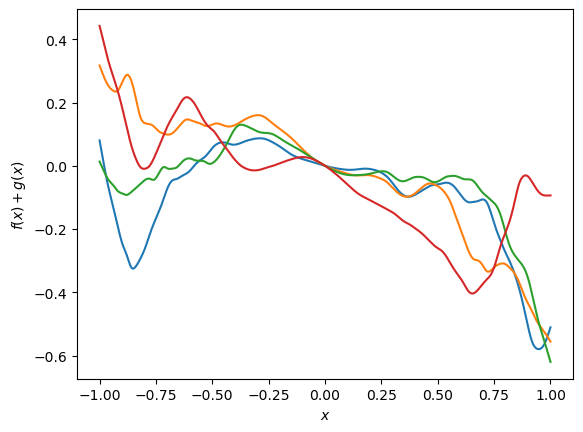

In [4]:
# ---------------------------------------------------------------------------*/
# - define stochastic dynamics

# specify model error as a kernel function
error_var = 0.2**2
error_lenscale = 0.2
error = (
    gpflow.kernels.Matern32(variance=error_var, lengthscales=error_lenscale) *
    gpflow.kernels.Linear())

# define observation noise
sample_ns_var = tf.constant(0.01 ** 2, dtype=gpflow.default_float())

dyn = fun.dynamics(dyn_linear, error, sample_ns_var)

# create an additional less-discretized domain to facilitate sampling
sample_dom = dom.gridworld(dim_lim, dims_sz=100)

# exemplify some samples from these stochastic dynamics
dyn_samples_n = 4
# initialize sampler for specified number of samples, and with no observation noise
dyn.initialize_sampler(discretization=sample_dom.states, samples_n=dyn_samples_n, noise_var=sample_ns_var)
# sample
dyn_samples = dyn(domain.states)
for sample in dyn_samples:
    # plot
    plt.plot(domain.states, sample)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)+g(x)$')
plt.show()

The choice of the Matern class of kernels is reasoned by a argument from Michael Stein who in 1999 claimed that the strong smoothness of a squared exponential kernel (very popular nowadays) is unrealistic for the modeling of many physical processes. Instead, he recommended using the Matern class. For example, the particular Matern kernel used here produces a one-time differentiable function. Combined with the linear kernel, the resulting function becomes two-times differentiable.

# Lyapunov-based stability analysis

Consider again the dynamics of the first-order model defined above

$f(x)=-0.25x$

Its phase portrait on the domain $[-1,1]$ reveals that states $x \neq 0$ eventually converge to $x=0$. In other words, the states are attracted to the origin and once there, the states remain still, see below. In such case, it is said that $x=0$ represents an equillibrium point.

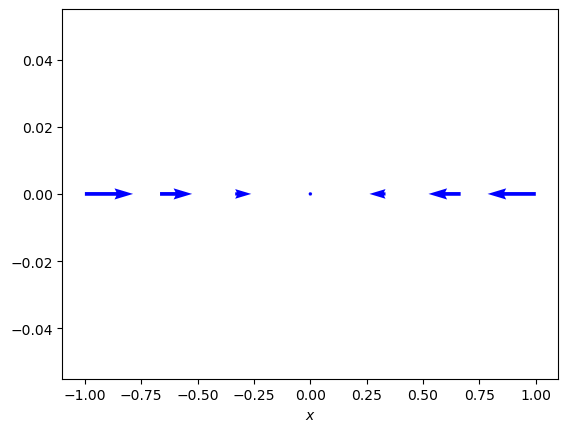

In [5]:
# ---------------------------------------------------------------------------*/
# - plot the phase portrait of a linear first-order model

# define a new domain for the phase portrait
# and determine model derivatives at these new points
pha_domain_X = dom.gridworld(dim_lim, 7).states
pha_value_X = dyn_linear(pha_domain_X).numpy()

# quiver method is designed to work with two-dimensional data,
# but f(x)=-0.25 is one-dimensional, so fill
# the second dimension with zeros.
pha_domain_Y = np.zeros_like(pha_domain_X)
pha_value_Y = np.zeros_like(pha_value_X)

# show the quiver plot
plt.quiver(
    pha_domain_X, pha_domain_Y,
    pha_value_X, pha_value_Y,
    color='blue')
plt.xlabel('$x$')
plt.show()

In order to analyze the stability of the equillibrium point at $x=0$ one can employ the Lyapunov stability theory. More specifically, this theory states that the origin of dynamics $f(x)$ is asymptotically stable within a region $\mathcal{V}$ if for all $x \in \mathcal{V}$

$\dot{V}(x)=\frac{\partial{V}}{\partial{x}}f(x)<0$.

To put it differently, the origin will attract system states from a nearby region $\mathcal{V}$ if the derivative of $V(x)$ along the trajectories of $f(x)$ is strictly negative. Function $V(x) : \mathcal{X} \rightarrow \mathbb{R}$ is a Lyapunov function, which satisfies

$V(0)=0$ and $V(x)>0 \;\, \forall x \in \mathcal{X} - \left\{0\right\}$,

$\dot{V}(x) \leq 0 \;\, \forall x \in \mathcal{X}$.

In general, it is not easy to find a suitable Lyapunov function, but for this simple example let $V(x) = x^2$, which obviously satisfies constraints on $V(x)$, as well as

$\dot{V}(x)=\frac{\partial{V}}{\partial{x}}f(x)=2x\cdot(-0.25x)=-0.5x^2<0 \;\, \forall x \in \mathcal{X} - \left\{0\right\}$,

which allows to conclude that the origin is asymptotically stable.

### Initial safe domain

Furthermore, it is helpful to specify some section of the overall domain, e.g. near the origin, which is deemed safe according to expert knowledge. For example, let $\mathcal{S}_0$ be this initial safe subset, such that

$\mathcal{S}_0 = \left\{ x \in \mathcal{X} \; | \; |x| < 0.2 \right\}$.

This safe region will be the starting point for a subsequent online learning.

In [6]:
# ---------------------------------------------------------------------------*/
# - lyapunov function

# As a lyapunov function candidate we choose a quadratic function V(x) = x^2,
# which is more generally expressed as V(x) = xT * P * x,
# where P is some positive-definite matrix,
# and where xT is the transpose of x.
lyap_candidate = fun.quadratic(tf.constant(1., dtype=gpflow.default_float()))

# specify safe initial domain
domain_safe = np.abs(domain.states.squeeze()) < 0.2

# instantiate a lyapunov framework
lyap = safe.lyapunov(lyap_candidate, dyn, domain, domain_safe)

### Lipschitz continuity

If a function is differentiable, then Lipschitz continuity defines a bound on the derivative of this function, such that

$|f(x)-f(x^\prime)| \leq L|x-x^\prime|$,

where $L$ is the smallest such bound, called Lipschitz constant. Loosely speaking, this bound reflects the amount of _wiggling_ a function performs. Obviously, such bound could help tailor a general Lyapunov derivative condition, in which $\dot{V}(x)<0$, to a specific function, thus yielding $\dot{V}(x)<-L$. At the same time, the domain in this example is discretized with the discretization step $\tau$. In order to account for this discretization step, the comparison is redefined as $\dot{V}(x)<-L\tau$.

To determine $L$ for the current example it is helpful to define $L=\max{f^\prime(x)}$, i.e. the maximum change of $f(x)$ on a bounded domain $\mathcal{X}$. Since $L$ in question is related to $\dot{V}(x)$, the standard Lipschitz continuity defined above could be reformulated as

$| \dot{V}(x) - \dot{V}(x^\prime) | \leq L | x - x^\prime |$, and then $L = \max{\dot{V^\prime}(x)}$.

But $\dot{V}(x) = \frac{\partial{V}(x)}{\partial{x}}\left[f(x) + g(x)\right]$, so applying the product rule yields

$\dot{V^\prime}(x) = \left(\frac{\partial{V}(x)}{\partial{x}} \right)^\prime \left[ f(x) + g(x)\right] + \frac{\partial{V}(x)}{\partial{x}} \left[ f^\prime(x) + g^\prime(x)\right]$.

As $L = \max{\dot{V^\prime}(x)}$, the terms in $\dot{V^\prime}(x)$ are redefined as follows

| Term | New term | New term explained |
| :-: | :-: | --- |
| $\left(\frac{\partial{V}(x)}{\partial{x}} \right)^\prime$ | $L_{\partial{V}}$ | $L_{\partial{V}} = \vert\vert\frac{\partial^2{V}(x)}{\partial{x}^2}\vert\vert_\infty$ |
| $f(x)$ | $B_f$ | $f(x)$ is bounded in $\mathcal{X}$ as $\vert\vert f \vert\vert_{\infty} \leq B_f$ |
| $g(x)$ | $B_g$ | $g(x)$ is bounded in $\mathcal{X}$ as $\vert\vert g \vert\vert_{\infty} \leq B_g$ |
| $\left(\frac{\partial{V}(x)}{\partial{x}} \right)$ | $L_V $ | $L_V = \vert\vert\frac{\partial{V}(x)}{\partial{x}}\vert\vert_\infty$ |
| $f^\prime(x)$ | $L_f$ | $L_f = \vert\vert f^\prime \vert\vert_{\infty}$ |
| $g^\prime(x)$ | $L_g$ | $L_g = \vert\vert g^\prime \vert\vert_{\infty}$ |

This yields $L = L_{\partial{V}} \left( B_f + B_g \right) + L_V \left( L_f + L_g \right)$.

Finally, a few words about $L_g = \vert\vert g^\prime \vert\vert_{\infty}$. The Lipschitz constant of the uncertain GP-based function $g(x)$ is encoded by its kernel. In fact, by the hyperparameters of this kernel. The Matern kernel has two such hyperparameters, which are relavent for this discussion: prior variance $\nu^2$ and lengthscale $l$. The former determines the expected magnitude of function values, such that $|g(x)| \leq \nu$ with 0.68 probability according to the Gaussian process prior. The latter determines how quickly the covariance between neighboring function values deteriorates with their distance. Loosely speaking, the lengthscale $l$ defines the amount of _wiggling_ of a GP. Following this, the Lipschitz constant depends on the ratio between $\nu$ and $l$, i.e. $\nu/l$. Intuitively, this ratio could be interpreted as something similar to the definition of a function derivative, i.e.

$f^\prime = \underset{\Delta x\rightarrow0}{\lim}\frac{\Delta y}{\Delta x}$.

In this case, $\nu$ would be similar to $\Delta{y}$, whereas $l$ to $\Delta{x}$.

In [7]:
# ---------------------------------------------------------------------------*/
# - determine lipschitz constant

lip_v = np.linalg.norm(lyap.candidate.differentiate(domain.states), ord=np.inf)

# here we use the fact that the second derivative of x^2 is
# (x^2)' -> (2x)' -> 2, so V^''(x) = 2 for all x,
# and infinity norm returns 2 as well.
lip_dv = np.linalg.norm([2], ord=np.inf)

# the first derivative of -0.25x is -0.25, so f'(x) = -0.25 for all x,
# but the infinity norm returns the largest magnitude,
# so the result will be 0.25.
lip_f = np.linalg.norm([-0.25], ord=np.inf)

# confidence interval is defined as 2 sigmas
lip_ci = 2.0
lip_g = (
    lip_ci *
    np.sqrt(error_var) / error_lenscale *
    np.linalg.norm(domain.dims_lim, ord=np.inf))

bnd_f = np.linalg.norm(dyn_linear(domain.states), ord=np.inf)

bnd_g = (
    np.sqrt(error_var) *
    np.linalg.norm(domain.dims_lim, ord=np.inf))

# lipschitz constant
lip = lip_dv * (bnd_f + bnd_g) + lip_v * (lip_f + lip_g)

lyap_threshold = -lip*tau

const_names = [
    'Ldv', 'Lv',
    'Lf', 'Lg',
    'Bf', 'Bg',
    'L']
const_values = [
    lip_dv, lip_v,
    lip_f, lip_g,
    bnd_f, bnd_g,
    lip]

print('constants of lipschitz continuity:')
for this, name in enumerate(const_names):
    print(f'{name:<4} {const_values[this]:.2f}')

print(f'safe threshold equals {lyap_threshold:.2f}')

constants of lipschitz continuity:
Ldv  2.00
Lv   2.00
Lf   0.25
Lg   4.00
Bf   0.25
Bg   0.40
L    9.80
safe threshold equals -0.02


Following all this, an initial Lyapunov-based safety analysis of the above-defined uncertain system can now be presented. It is seen, how the initial safe domain grants a safety certificate, despite $\dot{V}(x)$ being clearly above $-L\tau$ in $\mathcal{S}_0$.

In [8]:
# ---------------------------------------------------------------------------*/
# - function to plot dynamics and show results

def plot_dynamics(lyapunov: safe.lyapunov, threshold: float, ci: float = 2.0) -> None:
    """
    Plot ``lyapunov`` analysis of a stochastic model safety. The safety is
    determined based on safety ``threshold``.
    """

    # create figure axes
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # format axes
    axs[0].set_title('GP model of uncertain dynamics')
    axs[0].set_xlim(domain.dims_lim[0, :])
    axs[0].set_ylabel(r'$f(x) + g(x)$')
    axs[1].set_title('Lyapunov-based stability analysis')
    axs[1].set_xlim(domain.dims_lim[0, :])
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel(r'$\dot{V}(x)$')
    #axs[1].set_ylim([-0.5, 0.5])

    states = lyapunov.domain.states

    # mean and variance of uncertain dynamics
    dyn_mean, dyn_var = lyapunov.dynamics.evaluate_error(states)

    # plot the mean of dynamics
    dyn_mean_plt = axs[0].plot(
        states, dyn_mean,
        color='orange', linestyle='dashed', linewidth=1.5, label=r'mean')

    # plot sample from dynamics
    dyn_samples = lyapunov.dynamics(states)
    for dyn_sample in dyn_samples:
        dyn_sample_plt = axs[0].plot(
            states, dyn_sample,
            color='green', alpha=0.75, label=r'dynamics')

    # plot the confidence interval (ci) of dynamics
    dyn_ci = ci * tf.sqrt(dyn_var)
    dyn_ci_u = dyn_mean + dyn_ci
    dyn_ci_l = dyn_mean - dyn_ci
    axs[0].fill_between(
        states[:, 0],
        dyn_ci_u[:, 0], dyn_ci_l[:, 0],
        color='blue', alpha=0.1)

    # plot observed data
    dyn_data = lyapunov.dynamics.datapoints_observed
    axs[0].plot(
        tf.squeeze(dyn_data[0]), tf.squeeze(dyn_data[1]), # x and y
        'x', color='blue', ms=8, mew=2)

    # safety boundary by Lyapunov
    safety_mean, safety_var = lyapunov.evaluate_error()
    safety_err = ci * tf.sqrt(safety_var)

    # plot safety
    safety_err_u = safety_mean + safety_err
    safety_err_l = safety_mean - safety_err
    axs[1].fill_between(
        states[:, 0],
        safety_err_u[:, 0], safety_err_l[:, 0],
        color='blue', alpha=0.1)

    # plot sample from lyapunov
    lyap_sample = lyapunov.sample()
    lyap_sample_plt = axs[1].plot(
        states, lyap_sample,
        color='blue', alpha=0.75, label=r'lyapunov')

    # plot safety threshold
    axs[1].plot(*lyapunov.domain.dims_lim, [threshold, threshold], 'k-.')

    # plot boundary of the region of attraction
    if lyapunov.domain_safe_bdry is not None:
        x_safe = tf.squeeze(lyapunov.domain_safe_bdry, axis=-1)
        y_range = axs[1].get_ylim()
        axs[1].plot([x_safe, x_safe], y_range, 'k-.')
        axs[1].plot([-x_safe, -x_safe], y_range, 'k-.')

    # plot legend
    lns = dyn_mean_plt + dyn_sample_plt + lyap_sample_plt
    labels = [l.get_label() for l in lns]
    plt.legend(lns, labels, loc=1, fancybox=True, framealpha=0.75)

    plt.show()

In [9]:
# ---------------------------------------------------------------------------*/
# - preset random number generator to some value to get reproducible results

np.random.seed(4)

# reinitialize dynamics sampler
dyn.initialize_sampler(sample_dom.states, samples_n=1, noise_var=sample_ns_var)

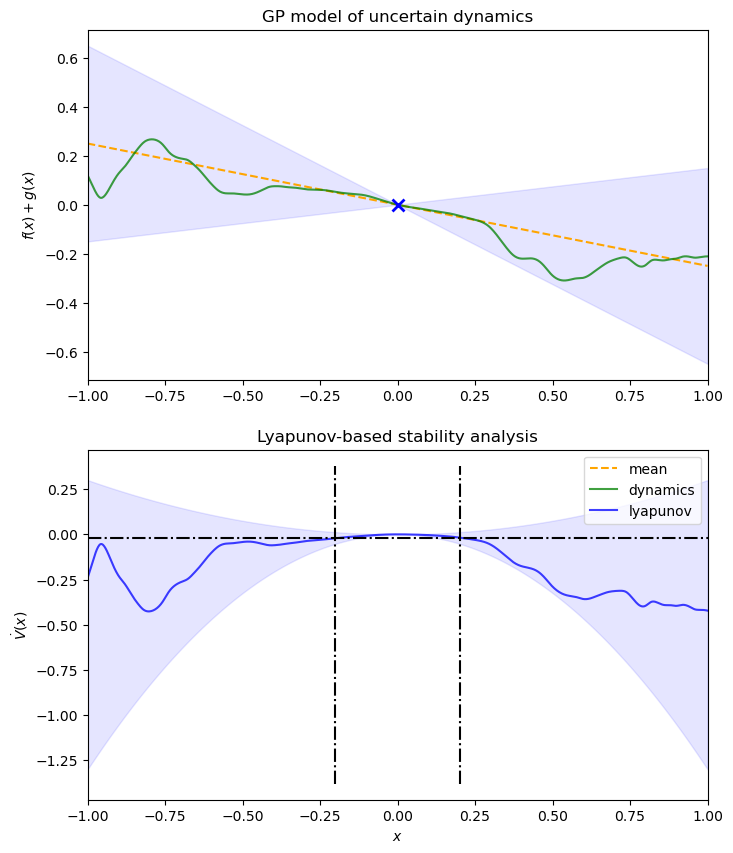

In [10]:
# ---------------------------------------------------------------------------*/
# - plot dynamics of uncertain system with lyapunov-based safety information

plot_dynamics(lyap, threshold=lyap_threshold, ci=lip_ci)

# Online learning

The online learning proceeds by sampling the uncertain function at points, which 1) are considered safe according to Lyapunov theory and which 2) have the most uncertainty, or variance. This is why, the first couple of samples are taken at the borders of the initial safe domain, see below.

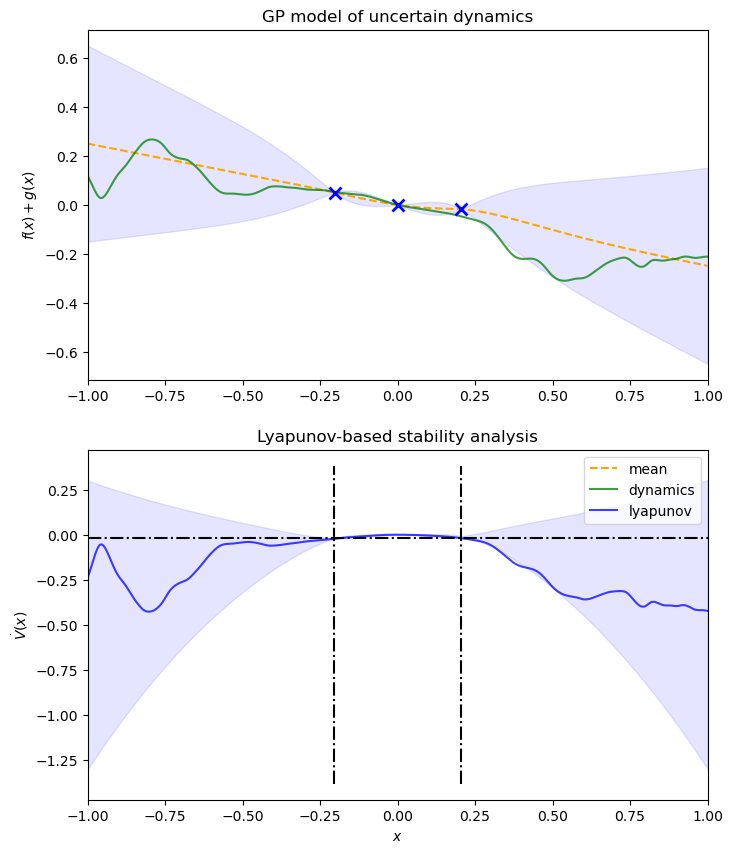

In [11]:
# ---------------------------------------------------------------------------*/
# - first samples of online learning

for i in range(2):
    lyap.update_safety(threshold=lyap_threshold)

    learnable_state = lyap.find_learnable()
    dyn.observe_datapoints(learnable_state, dyn(learnable_state, with_noise=True)[0])

plot_dynamics(lyap, threshold=lyap_threshold, ci=lip_ci)

Subsequent samples further decrease the uncertainty of the modeled system. This way, the knowledge regarding $\dot{V}(x)$ improves, and the safe domain expands. Note that the boundary of the safe domain is defined by the blue shaded area, see below. This is the upper bound of a 2-$\sigma$ confidence interval.

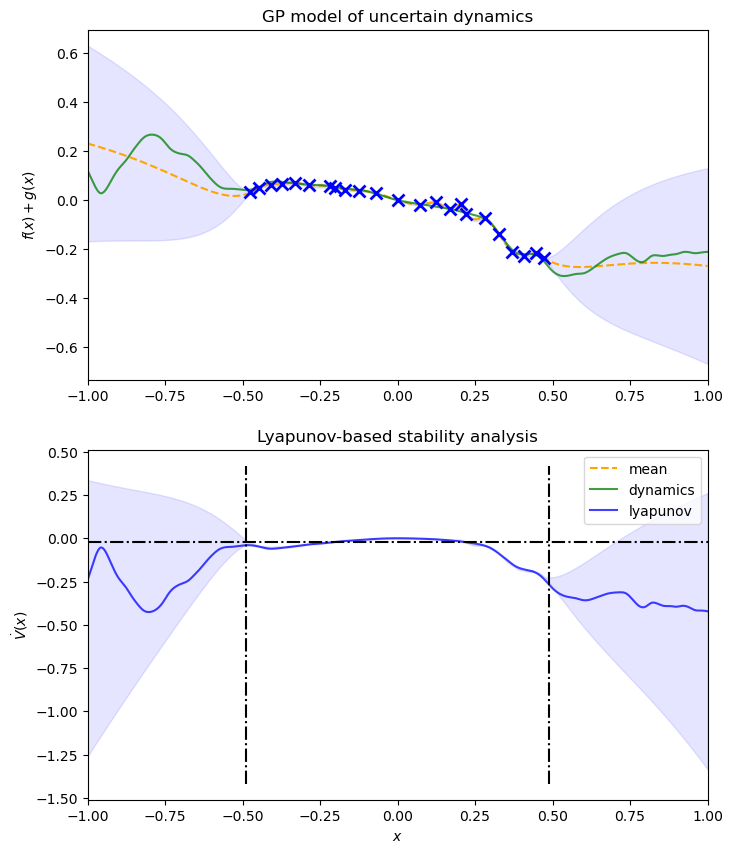

In [12]:
# ---------------------------------------------------------------------------*/
# - subsequent samples of online learning

for i in range(20):
    lyap.update_safety(threshold=lyap_threshold)

    learnable_state = lyap.find_learnable()
    dyn.observe_datapoints(learnable_state, dyn(learnable_state, with_noise=True)[0])

plot_dynamics(lyap, threshold=lyap_threshold, ci=lip_ci)